In [88]:
import pandas as pd
import json
from datetime import datetime
from datetime import time

In [31]:
time_series_path = 'caltech/California_Garage_01/'

In [21]:
json_path = 'caltech/acndata_sessions.json'

with open(json_path, 'r') as f:
    json_data = json.load(f)

In [24]:
json_data['_items'][1]

{'_id': '5c412c1df9af8b12cb56c281',
 'clusterID': '0039',
 'connectionTime': 'Tue, 01 Jan 2019 21:08:49 GMT',
 'disconnectTime': 'Tue, 01 Jan 2019 22:52:39 GMT',
 'doneChargingTime': 'Tue, 01 Jan 2019 22:17:15 GMT',
 'kWhDelivered': 2.917,
 'sessionID': '2_39_139_28_2019-01-01 21:08:49.264929',
 'siteID': '0002',
 'spaceID': 'CA-303',
 'stationID': '2-39-139-28',
 'timezone': 'America/Los_Angeles',
 'userID': '000000838',
 'userInputs': [{'WhPerMile': 433,
   'kWhRequested': 25.98,
   'milesRequested': 60,
   'minutesAvailable': 277,
   'modifiedAt': 'Tue, 01 Jan 2019 21:08:55 GMT',
   'paymentRequired': True,
   'requestedDeparture': 'Wed, 02 Jan 2019 01:45:49 GMT',
   'userID': 838}]}

In [19]:
data['_items'][0]['userInputs'][0]

{'WhPerMile': 400,
 'kWhRequested': 20.0,
 'milesRequested': 50,
 'minutesAvailable': 282,
 'modifiedAt': 'Tue, 01 Jan 2019 21:06:08 GMT',
 'paymentRequired': True,
 'requestedDeparture': 'Wed, 02 Jan 2019 01:47:57 GMT',
 'userID': 1135}

In [120]:
X = []
Y = []

for session in json_data['_items']:
    time_series_file = session['sessionID'].replace("_", "-" )
    time_series_file = time_series_file.replace(":", "-" )
    time_series_file = time_series_file.replace(".", "-" )
    time_series_file = time_series_file.replace(" ", "T" )
    
    try:
        kWhRequested = session['userInputs'][0]['kWhRequested']
        minutesAvailable = session['userInputs'][0]['minutesAvailable']
        modifiedAt = session['userInputs'][0]['modifiedAt']

        modifiedAt = datetime.strptime(modifiedAt[-12:-4], '%H:%M:%S')
        modifiedstart = arrival.replace(hour=0, minute=0, second = 0)
        modifiedAt = abs(modifiedAt - modifiedstart).total_seconds() / 3600.0

        milesRequested = session['userInputs'][0]['milesRequested']
        WhPerMile = session['userInputs'][0]['WhPerMile']
        userID = session['userInputs'][0]['userID']

        print(time_series_file)
        time_series_session = pd.read_csv(time_series_path + time_series_file + '.csv.gz', compression='gzip',
                   error_bad_lines=False)
            
        Y.append([kWhRequested, minutesAvailable, modifiedAt, milesRequested, WhPerMile, userID])
        X.append(time_series_session['Charging Current (A)'])
        
    except:
        print("An exception occurred")

2-39-79-378-2019-01-01T21-05-56-972890
2-39-139-28-2019-01-01T21-08-49-264929
An exception occurred
2-39-125-21-2019-01-01T22-23-40-471724
2-39-127-19-2019-01-02T13-53-10-182304
2-39-79-382-2019-01-02T15-53-25-247434
2-39-78-361-2019-01-02T16-12-38-806280
2-39-91-441-2019-01-02T16-18-35-672653
2-39-79-379-2019-01-02T16-18-55-665332
2-39-78-366-2019-01-02T16-23-56-085986
2-39-123-23-2019-01-02T16-27-57-366037
2-39-79-378-2019-01-02T16-33-49-779632
2-39-79-376-2019-01-02T16-34-33-982225
2-39-139-567-2019-01-02T16-36-32-018641
2-39-131-30-2019-01-02T16-37-52-964126
2-39-139-28-2019-01-02T16-38-59-827073
An exception occurred
2-39-130-564-2019-01-02T17-00-19-033308
2-39-89-25-2019-01-02T17-07-42-946454
2-39-91-437-2019-01-02T17-44-09-322050
2-39-79-377-2019-01-02T17-50-37-389194
2-39-78-365-2019-01-02T18-05-15-648844
2-39-79-381-2019-01-02T18-22-02-062348
2-39-95-444-2019-01-02T18-35-53-872924
2-39-79-380-2019-01-02T18-52-56-330038
2-39-95-27-2019-01-02T19-04-51-295367
An exception occurre

2-39-78-362-2019-01-09T21-48-10-584139
An exception occurred
An exception occurred
2-39-138-29-2019-01-10T00-33-14-249981
An exception occurred
2-39-131-30-2019-01-10T01-48-25-196478
2-39-79-380-2019-01-10T01-51-19-837751
2-39-126-20-2019-01-10T02-31-20-405006
An exception occurred
2-39-124-22-2019-01-10T03-07-04-683478
2-39-131-30-2019-01-10T15-11-04-194346
2-39-78-366-2019-01-10T15-16-00-074741
2-39-79-379-2019-01-10T15-54-21-585463
2-39-79-377-2019-01-10T16-00-43-417901
An exception occurred
An exception occurred
2-39-130-31-2019-01-10T16-49-38-735673
2-39-129-17-2019-01-10T16-51-37-343046
2-39-79-376-2019-01-10T17-06-42-330987
2-39-138-566-2019-01-10T17-07-24-871156
2-39-89-25-2019-01-10T17-09-00-222392
2-39-124-558-2019-01-10T17-41-59-932827
2-39-90-440-2019-01-10T17-47-25-010865
2-39-92-436-2019-01-10T17-50-16-182141
2-39-125-21-2019-01-10T18-00-48-209882
2-39-79-383-2019-01-10T18-12-39-718471
2-39-78-367-2019-01-10T18-15-13-951173
2-39-95-27-2019-01-10T18-17-17-261662
2-39-79-37

2-39-95-444-2019-01-16T17-45-43-434742
2-39-91-441-2019-01-16T17-51-11-354558
2-39-78-365-2019-01-16T17-53-46-318816
2-39-79-376-2019-01-16T17-56-59-996971
2-39-90-26-2019-01-16T17-59-51-707296
2-39-79-378-2019-01-16T18-10-38-369415
2-39-79-377-2019-01-16T18-14-28-117899
2-39-78-367-2019-01-16T18-14-59-782926
2-39-78-364-2019-01-16T18-24-43-451473
2-39-78-361-2019-01-16T18-27-08-074431
2-39-78-362-2019-01-16T19-01-51-478840
2-39-123-557-2019-01-16T20-28-32-645659
2-39-139-28-2019-01-16T20-51-52-033324
2-39-92-442-2019-01-16T20-52-54-997181
2-39-78-360-2019-01-16T21-02-48-837031
An exception occurred
2-39-139-28-2019-01-17T01-32-54-152062
2-39-128-18-2019-01-17T01-42-20-763533
2-39-130-31-2019-01-17T02-03-18-176557
An exception occurred
2-39-138-29-2019-01-17T04-39-56-309590
2-39-89-25-2019-01-17T14-00-21-917277
2-39-78-365-2019-01-17T15-17-41-104808
2-39-79-379-2019-01-17T15-59-13-904684
2-39-123-23-2019-01-17T16-03-59-206227
2-39-139-28-2019-01-17T16-23-53-444198
2-39-95-444-2019-01-1

2-39-79-378-2019-01-23T17-01-34-748766
2-39-91-437-2019-01-23T17-01-37-044473
An exception occurred
2-39-92-442-2019-01-23T17-05-09-450479
2-39-123-23-2019-01-23T17-09-22-447889
2-39-92-436-2019-01-23T17-09-44-364620
2-39-128-18-2019-01-23T17-10-51-639623
2-39-130-31-2019-01-23T17-13-51-216759
2-39-83-386-2019-01-23T17-16-54-943916
An exception occurred
2-39-88-438-2019-01-23T17-22-27-546420
An exception occurred
2-39-79-376-2019-01-23T18-09-38-935716
2-39-88-24-2019-01-23T18-41-21-671013
2-39-79-377-2019-01-23T18-47-13-227071
2-39-79-383-2019-01-23T18-53-23-487093
An exception occurred
2-39-78-362-2019-01-23T19-38-20-691269
2-39-78-361-2019-01-23T20-13-27-610866
2-39-78-365-2019-01-23T20-34-04-726606
2-39-95-27-2019-01-23T20-48-20-751264
2-39-138-29-2019-01-23T20-53-07-034538
2-39-78-367-2019-01-23T21-40-06-094862
2-39-130-31-2019-01-23T22-39-29-618721
An exception occurred
An exception occurred
2-39-78-363-2019-01-24T00-08-27-269688
2-39-129-17-2019-01-24T00-46-07-824845
An exception

2-39-131-30-2019-01-30T16-40-42-146788
2-39-139-28-2019-01-30T16-41-04-913882
2-39-79-380-2019-01-30T16-50-41-056323
2-39-79-379-2019-01-30T16-59-30-144344
2-39-124-558-2019-01-30T17-00-42-382422
2-39-78-366-2019-01-30T17-03-48-407784
2-39-123-23-2019-01-30T17-07-46-654608
2-39-83-386-2019-01-30T17-12-22-099663
2-39-91-437-2019-01-30T17-14-56-656458
2-39-95-27-2019-01-30T17-35-27-111944
2-39-126-20-2019-01-30T17-41-55-843797
2-39-79-381-2019-01-30T17-44-26-948363
An exception occurred
2-39-78-365-2019-01-30T18-00-18-591321
2-39-92-436-2019-01-30T18-07-35-572242
2-39-79-383-2019-01-30T18-09-35-476434
2-39-124-22-2019-01-30T18-10-39-064423
2-39-90-26-2019-01-30T18-19-31-482711
2-39-78-364-2019-01-30T18-32-30-221517
2-39-78-360-2019-01-30T18-47-41-442666
An exception occurred
2-39-95-444-2019-01-30T19-05-36-314489
2-39-91-441-2019-01-30T19-32-01-124993
2-39-78-367-2019-01-30T19-37-20-318638
2-39-123-557-2019-01-30T19-53-39-071977
2-39-79-381-2019-01-30T20-38-21-825223
An exception occurre

2-39-89-25-2019-02-06T16-52-02-404807
2-39-91-437-2019-02-06T16-58-54-265272
2-39-83-386-2019-02-06T17-02-42-061034
2-39-89-439-2019-02-06T17-04-57-532571
2-39-78-365-2019-02-06T17-06-52-734622
2-39-79-380-2019-02-06T17-07-23-772391
2-39-79-381-2019-02-06T17-19-24-314521
An exception occurred
An exception occurred
2-39-131-565-2019-02-06T17-42-21-866298
2-39-88-438-2019-02-06T18-01-44-270506
2-39-79-376-2019-02-06T18-02-38-019185
2-39-91-437-2019-02-06T18-21-51-296233
2-39-79-378-2019-02-06T18-47-45-126070
2-39-78-362-2019-02-06T19-04-09-845107
2-39-88-24-2019-02-06T19-33-30-246780
2-39-79-377-2019-02-06T20-30-17-235924
2-39-78-361-2019-02-06T21-02-58-070770
2-39-127-19-2019-02-06T21-04-00-668800
2-39-78-364-2019-02-06T21-05-19-101659
An exception occurred
An exception occurred
2-39-130-31-2019-02-06T23-32-48-445627
2-39-90-26-2019-02-06T23-49-16-580836
An exception occurred
2-39-130-31-2019-02-07T01-05-40-644944
2-39-129-17-2019-02-07T01-13-11-453183
2-39-139-28-2019-02-07T02-26-54-40

An exception occurred
An exception occurred
An exception occurred
2-39-92-442-2019-02-13T20-18-27-378617
2-39-79-377-2019-02-13T20-40-58-818703
2-39-78-361-2019-02-13T21-10-07-250365
2-39-79-381-2019-02-13T21-10-41-259590
An exception occurred
2-39-89-439-2019-02-13T22-08-01-677444
2-39-79-383-2019-02-13T22-46-46-729252
2-39-128-18-2019-02-14T01-05-45-062776
An exception occurred
2-39-127-19-2019-02-14T02-08-46-326007
An exception occurred
2-39-139-28-2019-02-14T02-22-28-620828
2-39-131-30-2019-02-14T03-02-18-999455
2-39-127-19-2019-02-14T05-18-42-018821
2-39-89-25-2019-02-14T13-58-48-719742
2-39-78-366-2019-02-14T15-19-17-153341
2-39-78-362-2019-02-14T15-58-24-572419
2-39-88-24-2019-02-14T16-04-11-644684
2-39-95-444-2019-02-14T16-11-56-900531
2-39-139-28-2019-02-14T16-28-20-381512
2-39-79-381-2019-02-14T16-32-38-883303
2-39-83-386-2019-02-14T16-36-11-813016
2-39-131-30-2019-02-14T16-40-36-398742
2-39-124-558-2019-02-14T16-46-19-511781
2-39-92-442-2019-02-14T16-48-05-171955
An exceptio

2-39-129-17-2019-02-21T16-53-49-231137
An exception occurred
2-39-125-21-2019-02-21T16-55-21-273351
2-39-127-19-2019-02-21T16-55-21-841856
2-39-95-27-2019-02-21T17-03-54-173867
2-39-79-377-2019-02-21T17-03-54-949687
2-39-89-25-2019-02-21T17-04-27-665247
2-39-91-437-2019-02-21T17-10-37-066492
2-39-124-22-2019-02-21T17-16-44-867099
2-39-79-381-2019-02-21T17-52-41-684908
2-39-90-26-2019-02-21T18-00-51-320716
2-39-95-27-2019-02-21T18-19-51-076322
2-39-78-361-2019-02-21T18-20-18-401722
2-39-79-378-2019-02-21T18-22-30-381835
2-39-126-560-2019-02-21T18-25-07-287957
2-39-79-376-2019-02-21T18-59-09-878482
2-39-89-439-2019-02-21T19-23-18-369428
2-39-123-23-2019-02-21T19-26-56-339499
2-39-79-383-2019-02-21T19-50-30-679643
2-39-83-386-2019-02-21T20-05-09-730169
2-39-78-365-2019-02-21T20-32-00-308141
2-39-78-362-2019-02-21T20-42-15-462400
An exception occurred
2-39-83-387-2019-02-21T21-48-18-482278
2-39-92-436-2019-02-21T22-04-52-999249
2-39-131-30-2019-02-21T22-14-02-780221
2-39-90-440-2019-02-21T

2-39-139-28-2019-02-28T02-30-05-566166
An exception occurred
2-39-127-19-2019-02-28T03-03-20-506429
An exception occurred
2-39-78-366-2019-02-28T03-31-33-651792
2-39-131-30-2019-02-28T04-00-49-048289
2-39-127-19-2019-02-28T05-07-59-983250
2-39-139-28-2019-02-28T06-07-29-400513
2-39-79-379-2019-02-28T15-50-33-268454
2-39-78-364-2019-02-28T15-51-51-065929
2-39-123-23-2019-02-28T15-56-18-289560
2-39-92-442-2019-02-28T16-23-11-434152
2-39-131-30-2019-02-28T16-25-00-861947
2-39-124-558-2019-02-28T16-36-38-065552
2-39-79-378-2019-02-28T16-39-15-271724
2-39-95-444-2019-02-28T16-41-25-868717
An exception occurred
An exception occurred
2-39-79-377-2019-02-28T16-57-15-337398
2-39-89-25-2019-02-28T17-09-20-977720
An exception occurred
2-39-79-380-2019-02-28T17-17-09-906044
2-39-123-557-2019-02-28T17-20-11-644279
2-39-79-383-2019-02-28T17-24-48-712692
2-39-95-27-2019-02-28T17-49-52-539696
2-39-91-437-2019-02-28T18-13-03-616725
2-39-79-376-2019-02-28T18-15-02-942451
An exception occurred
An excepti

2-39-95-27-2019-03-07T18-02-01-567046
2-39-92-442-2019-03-07T18-20-46-487950
An exception occurred
An exception occurred
2-39-78-365-2019-03-07T18-40-05-102223
2-39-78-367-2019-03-07T19-03-59-792267
2-39-92-436-2019-03-07T19-43-57-078543
2-39-90-26-2019-03-07T19-49-03-488191
2-39-91-437-2019-03-07T19-53-40-418410
2-39-78-362-2019-03-07T20-25-47-250919
2-39-88-438-2019-03-07T20-45-34-595732
2-39-125-21-2019-03-07T21-11-53-440329
2-39-78-360-2019-03-07T22-29-13-508517
An exception occurred
An exception occurred
2-39-131-30-2019-03-08T01-04-59-844127
An exception occurred
2-39-91-437-2019-03-08T01-54-18-647839
An exception occurred
2-39-125-21-2019-03-08T03-39-27-620638
An exception occurred
2-39-123-23-2019-03-08T04-08-45-832253
2-39-79-382-2019-03-08T04-43-31-271946
2-39-138-29-2019-03-08T04-49-41-565567
2-39-89-25-2019-03-08T14-06-58-131313
2-39-78-366-2019-03-08T15-29-17-548894
2-39-125-21-2019-03-08T15-58-20-775877
An exception occurred
2-39-79-380-2019-03-08T16-02-11-857444
2-39-92-

2-39-78-363-2019-03-14T16-11-36-901021
2-39-92-436-2019-03-14T16-26-33-159947
An exception occurred
2-39-79-382-2019-03-14T16-29-40-810956
2-39-128-18-2019-03-14T16-30-25-598546
2-39-78-361-2019-03-14T16-33-00-195761
2-39-89-25-2019-03-14T16-40-04-065703
2-39-90-440-2019-03-14T16-45-17-111077
2-39-90-26-2019-03-14T17-21-39-451796
2-39-78-365-2019-03-14T17-24-36-895066
2-39-91-437-2019-03-14T18-15-32-302739
An exception occurred
2-39-89-439-2019-03-14T18-44-10-895926
2-39-91-441-2019-03-14T19-34-49-655930
2-39-78-366-2019-03-14T19-37-03-256513
2-39-78-360-2019-03-14T19-50-01-286957
An exception occurred
2-39-88-24-2019-03-14T20-35-36-930244
2-39-124-22-2019-03-14T20-48-19-681914
An exception occurred
An exception occurred
2-39-79-376-2019-03-14T23-02-24-638283
2-39-127-19-2019-03-14T23-32-17-705931
2-39-130-31-2019-03-15T00-00-46-779692
2-39-127-19-2019-03-15T00-48-24-846758
An exception occurred
2-39-79-377-2019-03-15T02-25-25-813267
2-39-125-21-2019-03-15T02-34-14-882134
2-39-128-18-2

An exception occurred
2-39-123-557-2019-03-20T20-31-32-128737
An exception occurred
2-39-127-19-2019-03-20T22-49-12-066033
2-39-79-376-2019-03-20T22-51-47-841308
2-39-123-23-2019-03-20T23-33-51-309015
2-39-91-437-2019-03-21T00-06-31-667165
An exception occurred
2-39-131-30-2019-03-21T01-07-33-103411
2-39-139-28-2019-03-21T01-21-33-913043
2-39-129-17-2019-03-21T02-00-12-680649
2-39-127-19-2019-03-21T02-17-21-020495
2-39-79-383-2019-03-21T02-20-21-441197
2-39-125-21-2019-03-21T02-28-40-507342
2-39-89-25-2019-03-21T02-32-21-677044
2-39-138-29-2019-03-21T03-02-44-658341
2-39-78-366-2019-03-21T03-36-25-456897
2-39-131-30-2019-03-21T04-14-48-383940
2-39-127-19-2019-03-21T04-50-42-708039
2-39-89-25-2019-03-21T13-21-35-468351
2-39-123-23-2019-03-21T14-59-31-403109
2-39-78-364-2019-03-21T15-21-37-850798
2-39-126-560-2019-03-21T15-24-14-885379
2-39-139-28-2019-03-21T15-24-20-013613
2-39-127-19-2019-03-21T15-33-50-422811
An exception occurred
2-39-79-376-2019-03-21T15-41-02-146802
2-39-92-442-201

2-39-78-365-2019-03-28T14-56-26-770405
2-39-90-26-2019-03-28T15-01-44-259049
2-39-79-380-2019-03-28T15-33-16-407867
2-39-91-437-2019-03-28T15-41-15-064461
2-39-92-442-2019-03-28T15-45-04-980477
2-39-131-30-2019-03-28T15-48-10-111496
2-39-79-381-2019-03-28T15-49-00-437700
2-39-78-360-2019-03-28T16-01-04-773168
2-39-79-382-2019-03-28T16-01-31-903518
2-39-78-367-2019-03-28T16-02-00-538978
2-39-89-25-2019-03-28T16-03-13-962419
An exception occurred
2-39-129-17-2019-03-28T16-20-32-874574
2-39-83-386-2019-03-28T16-32-22-502452
2-39-127-19-2019-03-28T16-44-12-065295
2-39-95-27-2019-03-28T17-00-38-539436
2-39-123-23-2019-03-28T17-17-39-765788
2-39-79-377-2019-03-28T17-45-53-777875
2-39-79-378-2019-03-28T17-52-48-080244
2-39-79-376-2019-03-28T17-58-25-125372
An exception occurred
2-39-129-17-2019-03-28T19-20-02-488536
An exception occurred
An exception occurred
2-39-92-436-2019-03-28T19-43-03-848809
An exception occurred
2-39-91-441-2019-03-28T20-45-42-930497
An exception occurred
2-39-78-361-2

2-39-88-438-2019-04-04T20-02-20-677373
2-39-123-23-2019-04-04T20-33-16-085581
2-39-83-386-2019-04-04T20-37-17-670621
An exception occurred
2-39-88-24-2019-04-04T21-15-31-823178
2-39-78-364-2019-04-04T21-34-25-742587
An exception occurred
2-39-123-23-2019-04-04T22-26-02-378645
2-39-91-441-2019-04-04T22-27-26-133566
2-39-128-18-2019-04-04T23-52-23-509076
2-39-79-377-2019-04-05T00-56-45-122638
2-39-78-365-2019-04-05T02-07-04-490521
2-39-139-28-2019-04-05T03-28-25-429567
An exception occurred
2-39-89-25-2019-04-05T13-21-19-543282
2-39-78-366-2019-04-05T14-09-12-656282
2-39-78-367-2019-04-05T14-35-17-571956
2-39-79-382-2019-04-05T14-59-06-186519
2-39-79-381-2019-04-05T15-13-25-648864
An exception occurred
2-39-139-28-2019-04-05T15-21-49-123303
2-39-79-378-2019-04-05T15-27-05-518227
2-39-79-377-2019-04-05T15-27-30-111443
2-39-91-441-2019-04-05T15-57-50-055170
2-39-92-442-2019-04-05T15-58-17-967394
2-39-131-30-2019-04-05T16-11-29-746484
2-39-89-25-2019-04-05T16-30-20-887179
2-39-123-23-2019-0

2-39-95-27-2019-04-11T15-34-30-116157
2-39-79-380-2019-04-11T15-39-47-261840
2-39-131-30-2019-04-11T15-49-49-985574
2-39-92-436-2019-04-11T16-09-02-223464
2-39-126-560-2019-04-11T16-15-22-924573
2-39-89-25-2019-04-11T16-21-53-243683
2-39-79-376-2019-04-11T16-29-04-010946
2-39-78-362-2019-04-11T16-35-01-959064
2-39-95-444-2019-04-11T16-51-33-957211
2-39-130-564-2019-04-11T17-33-37-764016
2-39-128-18-2019-04-11T17-48-34-381478
An exception occurred
An exception occurred
2-39-129-17-2019-04-11T18-39-33-554593
An exception occurred
2-39-79-378-2019-04-11T19-14-11-867316
2-39-125-21-2019-04-11T19-19-02-916605
2-39-78-363-2019-04-11T19-23-20-779186
2-39-88-24-2019-04-11T19-56-26-401839
An exception occurred
2-39-90-440-2019-04-11T20-02-54-438027
2-39-79-383-2019-04-11T20-58-29-444009
2-39-79-377-2019-04-11T22-50-56-027221
2-39-130-31-2019-04-11T23-08-15-126127
2-39-89-25-2019-04-12T00-52-12-327996
2-39-129-17-2019-04-12T00-57-00-618904
2-39-88-24-2019-04-12T01-14-03-589561
2-39-138-29-2019-0

2-39-89-25-2019-04-17T20-58-20-867776
2-39-139-567-2019-04-17T21-33-57-856025
An exception occurred
2-39-88-24-2019-04-17T23-33-14-019053
2-39-129-17-2019-04-18T01-19-45-560320
2-39-139-28-2019-04-18T01-33-13-972586
2-39-127-19-2019-04-18T01-55-46-739007
2-39-138-29-2019-04-18T02-15-11-203670
2-39-128-18-2019-04-18T02-50-38-790340
2-39-79-382-2019-04-18T04-14-15-576473
2-39-79-379-2019-04-18T06-23-12-018873
2-39-88-24-2019-04-18T13-34-42-195295
2-39-78-366-2019-04-18T14-13-33-154989
2-39-78-367-2019-04-18T14-52-58-955928
2-39-127-19-2019-04-18T15-01-41-620155
An exception occurred
2-39-89-25-2019-04-18T15-28-49-951242
2-39-79-377-2019-04-18T15-31-38-064408
2-39-139-28-2019-04-18T15-44-33-137599
2-39-131-30-2019-04-18T15-45-03-448671
2-39-129-17-2019-04-18T16-02-04-486254
2-39-78-361-2019-04-18T16-03-09-113014
2-39-90-26-2019-04-18T16-17-39-555171
2-39-79-381-2019-04-18T16-17-53-492189
2-39-79-376-2019-04-18T16-18-09-454721
2-39-95-27-2019-04-18T16-32-04-077679
2-39-79-382-2019-04-18T16

An exception occurred
2-39-79-382-2019-04-24T21-54-41-327990
An exception occurred
2-39-79-379-2019-04-25T00-36-07-469497
2-39-130-31-2019-04-25T01-21-17-564385
2-39-139-28-2019-04-25T01-34-56-433139
2-39-131-30-2019-04-25T01-53-03-823762
2-39-126-20-2019-04-25T02-51-17-401134
2-39-88-24-2019-04-25T13-29-33-901275
2-39-78-366-2019-04-25T14-14-43-632001
2-39-123-23-2019-04-25T14-56-24-973276
2-39-79-379-2019-04-25T14-59-51-222209
2-39-78-365-2019-04-25T15-18-34-216954
2-39-139-28-2019-04-25T15-22-52-713652
2-39-79-377-2019-04-25T15-28-02-391989
2-39-131-30-2019-04-25T15-30-18-507850
2-39-138-29-2019-04-25T15-48-46-930212
2-39-124-558-2019-04-25T15-48-54-723737
2-39-129-17-2019-04-25T15-49-41-088498
2-39-89-25-2019-04-25T15-52-33-239673
2-39-79-383-2019-04-25T16-04-30-864085
2-39-78-363-2019-04-25T16-06-20-450162
2-39-79-376-2019-04-25T16-23-20-691493
2-39-90-26-2019-04-25T16-26-12-486078
2-39-78-360-2019-04-25T16-27-00-829040
2-39-79-381-2019-04-25T16-27-23-243963
2-39-78-362-2019-04-25

2-39-89-25-2019-05-01T16-05-58-363347
2-39-78-360-2019-05-01T16-13-17-462183
2-39-123-23-2019-05-01T16-21-33-604642
2-39-90-26-2019-05-01T16-37-15-246069
2-39-89-439-2019-05-01T16-48-02-613902
2-39-78-363-2019-05-01T16-50-58-314373
An exception occurred
2-39-90-440-2019-05-01T16-53-49-397821
2-39-78-362-2019-05-01T16-58-51-960389
2-39-95-444-2019-05-01T17-19-01-874288
2-39-91-441-2019-05-01T17-26-10-624460
2-39-124-22-2019-05-01T17-59-37-023704
2-39-88-24-2019-05-01T19-23-06-104633
2-39-79-378-2019-05-01T19-25-03-085152
2-39-128-18-2019-05-01T20-50-20-478241
2-39-123-23-2019-05-01T21-09-06-461400
An exception occurred
2-39-78-367-2019-05-01T22-01-12-391393
2-39-139-28-2019-05-01T23-38-44-276748
2-39-126-20-2019-05-02T01-21-53-704574
2-39-88-24-2019-05-02T13-38-09-368662
2-39-78-366-2019-05-02T14-07-35-468285
2-39-79-379-2019-05-02T14-12-16-157954
2-39-131-30-2019-05-02T15-00-18-523087
An exception occurred
2-39-139-28-2019-05-02T15-30-41-751896
2-39-89-25-2019-05-02T15-40-09-313476
2-3

2-39-78-361-2019-05-08T19-34-14-109568
2-39-78-362-2019-05-08T19-55-56-059964
An exception occurred
2-39-92-442-2019-05-08T20-35-04-105284
2-39-78-364-2019-05-08T20-48-18-823815
An exception occurred
2-39-78-361-2019-05-08T23-21-00-745604
2-39-138-29-2019-05-09T01-29-07-465368
2-39-131-30-2019-05-09T01-47-30-976644
2-39-129-17-2019-05-09T03-04-30-129991
2-39-139-28-2019-05-09T05-01-34-038650
2-39-88-24-2019-05-09T13-30-55-133277
2-39-79-379-2019-05-09T14-11-06-944152
2-39-79-376-2019-05-09T14-13-44-392771
2-39-78-367-2019-05-09T14-58-31-747097
2-39-125-21-2019-05-09T15-06-00-222097
2-39-79-377-2019-05-09T15-18-05-772756
An exception occurred
2-39-131-30-2019-05-09T15-27-34-822756
2-39-129-17-2019-05-09T15-27-43-229563
2-39-127-19-2019-05-09T15-28-35-482330
2-39-78-365-2019-05-09T15-34-29-743737
2-39-89-25-2019-05-09T15-50-01-519210
An exception occurred
An exception occurred
2-39-91-437-2019-05-09T16-26-15-889522
2-39-79-383-2019-05-09T17-03-57-244871
2-39-126-20-2019-05-09T17-07-08-98

2-39-139-28-2019-05-16T06-54-32-086138
2-39-95-27-2019-05-16T13-17-17-918794
2-39-88-24-2019-05-16T13-36-05-783789
An exception occurred
2-39-78-366-2019-05-16T14-09-35-278247
2-39-78-364-2019-05-16T14-28-44-921175
2-39-123-23-2019-05-16T15-07-55-722587
2-39-124-558-2019-05-16T15-35-36-976513
2-39-91-437-2019-05-16T15-45-36-499298
2-39-129-17-2019-05-16T15-55-27-411308
2-39-79-379-2019-05-16T16-04-06-757322
2-39-79-383-2019-05-16T16-05-52-032632
2-39-95-27-2019-05-16T16-27-34-327553
2-39-89-439-2019-05-16T16-27-49-962650
2-39-78-365-2019-05-16T16-44-08-640150
2-39-79-376-2019-05-16T17-01-20-715858
2-39-79-378-2019-05-16T17-08-31-423208
2-39-78-361-2019-05-16T17-11-36-063370
2-39-78-363-2019-05-16T18-02-56-107407
2-39-124-22-2019-05-16T18-03-06-986702
2-39-83-386-2019-05-16T18-19-40-147213
2-39-79-382-2019-05-16T18-24-48-377292
2-39-78-360-2019-05-16T18-29-15-339242
2-39-92-442-2019-05-16T19-15-41-212648
2-39-79-376-2019-05-16T19-15-47-227267
2-39-130-31-2019-05-16T19-22-12-701074
2-39-

2-39-79-377-2019-05-22T23-18-47-007587
An exception occurred
2-39-139-28-2019-05-23T01-35-36-407581
An exception occurred
2-39-131-30-2019-05-23T04-15-43-425460
An exception occurred
2-39-78-366-2019-05-23T14-24-19-406776
An exception occurred
An exception occurred
2-39-79-379-2019-05-23T15-04-54-263543
2-39-95-27-2019-05-23T15-11-29-192804
An exception occurred
2-39-89-25-2019-05-23T15-20-29-489892
2-39-78-364-2019-05-23T15-30-03-989162
2-39-79-377-2019-05-23T15-36-15-498781
2-39-131-30-2019-05-23T15-46-00-336294
An exception occurred
2-39-129-17-2019-05-23T15-56-03-604498
2-39-90-26-2019-05-23T16-13-09-550787
2-39-79-376-2019-05-23T16-13-19-314484
2-39-79-382-2019-05-23T16-16-58-316615
An exception occurred
2-39-79-380-2019-05-23T16-28-38-027363
2-39-127-19-2019-05-23T16-34-27-798269
2-39-95-444-2019-05-23T17-09-08-001476
2-39-123-23-2019-05-23T17-33-25-610476
An exception occurred
2-39-126-20-2019-05-23T17-36-10-196176
2-39-78-365-2019-05-23T17-41-39-792886
2-39-78-363-2019-05-23T17

2-39-130-31-2019-05-31T16-15-02-421753
2-39-129-17-2019-05-31T16-18-24-467004
2-39-91-437-2019-05-31T16-33-37-472216
2-39-92-436-2019-05-31T16-42-59-905350
An exception occurred
2-39-79-380-2019-05-31T17-06-58-226649
2-39-78-363-2019-05-31T17-08-57-218129
2-39-90-26-2019-05-31T17-10-12-816876
2-39-88-24-2019-05-31T17-19-13-624612
An exception occurred
2-39-79-379-2019-05-31T17-59-09-451509
2-39-124-22-2019-05-31T18-01-13-015421
2-39-79-376-2019-05-31T18-13-21-455008
2-39-78-365-2019-05-31T18-24-40-762331
2-39-79-381-2019-05-31T18-56-00-522524
2-39-90-440-2019-05-31T19-03-42-445922
2-39-78-367-2019-05-31T19-06-11-791688
2-39-78-361-2019-05-31T19-23-02-802940
2-39-92-436-2019-05-31T19-43-01-396683
An exception occurred
2-39-79-382-2019-05-31T20-22-07-081114
An exception occurred
2-39-79-376-2019-05-31T22-12-41-349691
2-39-78-360-2019-05-31T22-26-38-722885
2-39-139-28-2019-05-31T22-41-51-375865
2-39-131-30-2019-06-01T01-09-08-646704
2-39-139-28-2019-06-01T04-32-22-861721
2-39-129-17-2019-

2-39-78-360-2019-06-07T20-17-08-653488
2-39-79-383-2019-06-07T21-00-24-259239
An exception occurred
2-39-127-19-2019-06-07T22-50-13-078217
2-39-78-366-2019-06-08T00-35-10-541193
An exception occurred
An exception occurred
2-39-129-17-2019-06-08T04-28-46-786624
2-39-139-28-2019-06-08T14-58-06-469599
2-39-89-25-2019-06-08T15-49-15-983025
2-39-131-30-2019-06-08T17-54-38-688264
2-39-125-21-2019-06-08T18-39-33-510121
2-39-131-30-2019-06-08T18-57-53-529106
2-39-95-27-2019-06-08T20-51-33-959304
An exception occurred
2-39-95-27-2019-06-08T23-12-37-152585
2-39-139-28-2019-06-08T23-13-46-627505
2-39-129-17-2019-06-09T00-21-45-752479
2-39-139-28-2019-06-09T15-38-37-214155
2-39-89-25-2019-06-09T16-10-43-922380
An exception occurred
2-39-79-377-2019-06-09T20-11-40-113030
2-39-139-28-2019-06-09T22-25-28-059696
2-39-125-21-2019-06-09T22-54-47-217067
2-39-131-30-2019-06-10T00-01-08-018330
2-39-139-28-2019-06-10T01-33-39-829561
2-39-79-377-2019-06-10T02-41-35-615545
2-39-79-381-2019-06-10T04-26-44-5081

2-39-79-383-2019-06-14T23-55-51-470059
2-39-89-25-2019-06-15T01-27-23-733680
2-39-139-28-2019-06-15T04-34-58-088957
2-39-131-30-2019-06-15T09-41-34-069130
2-39-79-376-2019-06-15T14-42-58-743702
2-39-129-17-2019-06-15T15-12-08-135069
2-39-127-19-2019-06-15T16-32-41-198557
2-39-138-29-2019-06-15T16-35-34-199984
2-39-91-437-2019-06-15T16-44-36-874312
2-39-129-17-2019-06-15T17-01-18-451891
2-39-89-439-2019-06-15T19-51-08-925953
2-39-139-28-2019-06-15T21-40-51-806421
2-39-95-27-2019-06-15T22-01-39-630389
2-39-125-21-2019-06-15T22-33-32-940561
2-39-91-437-2019-06-15T22-38-21-578946
2-39-129-17-2019-06-15T23-42-39-217356
2-39-79-377-2019-06-16T05-12-33-999057
2-39-139-28-2019-06-16T05-34-51-720043
2-39-89-25-2019-06-16T13-49-45-076032
2-39-129-17-2019-06-16T15-07-04-826629
2-39-127-19-2019-06-16T18-43-16-382496
2-39-95-27-2019-06-16T19-13-31-587645
2-39-126-20-2019-06-16T21-49-37-288313
2-39-125-21-2019-06-17T13-33-21-297950
2-39-78-366-2019-06-17T14-34-32-999979
An exception occurred
2-39-12

An exception occurred
An exception occurred
2-39-125-21-2019-06-24T13-35-41-290306
2-39-89-25-2019-06-24T13-35-47-356542
An exception occurred
2-39-79-379-2019-06-24T15-32-54-019550
2-39-129-17-2019-06-24T15-39-26-129574
2-39-131-30-2019-06-24T15-40-51-829741
2-39-79-382-2019-06-24T15-42-28-233321
2-39-127-19-2019-06-24T15-47-30-399083
2-39-79-383-2019-06-24T16-02-37-796424
2-39-79-380-2019-06-24T16-04-30-059190
2-39-91-441-2019-06-24T16-05-35-043964
2-39-92-436-2019-06-24T16-15-03-599787
2-39-78-366-2019-06-24T16-25-11-962957
2-39-78-365-2019-06-24T16-27-15-612628
2-39-95-27-2019-06-24T16-30-16-946258
2-39-89-25-2019-06-24T16-35-36-505629
2-39-78-367-2019-06-24T16-42-08-693195
2-39-124-22-2019-06-24T16-46-11-560123
2-39-78-364-2019-06-24T16-49-30-850834
2-39-78-360-2019-06-24T17-02-59-680983
2-39-90-440-2019-06-24T17-07-22-435418
2-39-78-362-2019-06-24T17-21-41-704585
2-39-79-376-2019-06-24T17-24-19-981852
2-39-79-378-2019-06-24T17-24-32-408154
An exception occurred
2-39-91-437-2019-0

2-39-79-383-2019-07-02T15-39-04-380144
2-39-79-379-2019-07-02T15-40-09-732132
2-39-130-31-2019-07-02T15-56-37-881639
2-39-131-30-2019-07-02T16-03-51-404814
2-39-129-17-2019-07-02T16-04-10-622084
2-39-138-29-2019-07-02T16-06-23-881211
2-39-89-439-2019-07-02T16-10-32-762046
2-39-89-25-2019-07-02T16-12-54-614710
2-39-123-23-2019-07-02T16-21-50-124525
2-39-95-27-2019-07-02T16-29-16-328162
2-39-78-365-2019-07-02T16-33-17-140437
An exception occurred
2-39-90-26-2019-07-02T16-58-43-198654
2-39-78-364-2019-07-02T17-05-56-171909
2-39-95-444-2019-07-02T17-07-30-040633
2-39-91-441-2019-07-02T17-12-59-353620
An exception occurred
An exception occurred
An exception occurred
2-39-88-24-2019-07-02T20-15-44-477645
2-39-78-360-2019-07-02T22-33-09-168736
2-39-125-21-2019-07-02T23-00-57-948439
2-39-78-363-2019-07-02T23-45-01-519590
2-39-138-29-2019-07-03T00-16-57-122921
2-39-89-25-2019-07-03T13-01-54-393867
2-39-128-18-2019-07-03T14-40-52-787284
2-39-79-383-2019-07-03T15-14-47-181804
2-39-79-379-2019-07-

2-39-124-22-2019-07-12T17-23-40-976753
2-39-79-377-2019-07-12T17-30-11-044507
2-39-79-378-2019-07-12T17-34-31-446959
2-39-79-382-2019-07-12T17-50-05-533175
2-39-95-27-2019-07-12T18-20-59-539667
2-39-78-365-2019-07-12T18-39-33-083935
2-39-138-29-2019-07-12T19-02-45-552615
2-39-88-24-2019-07-12T19-40-24-260272
2-39-92-442-2019-07-12T19-48-42-373249
An exception occurred
2-39-79-376-2019-07-12T20-41-24-351059
An exception occurred
2-39-92-436-2019-07-12T20-45-51-251731
2-39-78-360-2019-07-12T21-09-27-753948
2-39-79-377-2019-07-12T21-44-05-545954
2-39-78-362-2019-07-12T21-49-06-880351
2-39-123-23-2019-07-12T22-11-26-252856
An exception occurred
2-39-78-367-2019-07-12T23-22-30-897973
2-39-79-377-2019-07-12T23-32-43-290191
2-39-95-27-2019-07-13T01-04-19-562260
An exception occurred
2-39-139-28-2019-07-13T04-42-22-931752
2-39-138-29-2019-07-13T15-13-53-138157
An exception occurred
2-39-127-19-2019-07-13T16-45-31-311280
2-39-139-28-2019-07-13T17-11-46-159882
2-39-125-21-2019-07-13T22-59-54-957

2-39-138-29-2019-07-20T00-25-49-913970
2-39-139-28-2019-07-20T02-24-56-592913
2-39-131-30-2019-07-20T14-56-09-216589
2-39-127-19-2019-07-20T16-20-57-194008
2-39-139-28-2019-07-20T16-46-22-758901
2-39-124-22-2019-07-20T17-35-47-862772
2-39-89-25-2019-07-20T23-00-40-543955
2-39-139-28-2019-07-21T03-45-27-534113
An exception occurred
2-39-131-30-2019-07-21T18-53-51-015449
An exception occurred
2-39-139-28-2019-07-21T22-17-19-376033
2-39-138-29-2019-07-21T22-38-23-738628
An exception occurred
2-39-95-27-2019-07-21T23-15-25-870939
2-39-139-28-2019-07-22T01-18-35-793315
An exception occurred
2-39-128-18-2019-07-22T04-32-15-787070
2-39-139-28-2019-07-22T06-47-03-086188
2-39-78-360-2019-07-22T14-01-50-427628
2-39-138-29-2019-07-22T14-54-07-371419
2-39-79-380-2019-07-22T15-35-27-403460
2-39-131-30-2019-07-22T15-36-05-885755
2-39-129-17-2019-07-22T15-40-41-761657
2-39-79-382-2019-07-22T16-01-14-027780
2-39-127-19-2019-07-22T16-06-08-264251
2-39-89-25-2019-07-22T16-09-27-601262
2-39-78-362-2019-0

2-39-78-365-2019-07-29T16-06-33-585578
2-39-130-31-2019-07-29T16-08-37-030098
2-39-79-380-2019-07-29T16-09-33-196124
2-39-125-21-2019-07-29T16-11-42-432606
2-39-89-25-2019-07-29T16-17-58-748820
An exception occurred
2-39-90-440-2019-07-29T16-35-33-009903
2-39-91-437-2019-07-29T16-39-29-987708
2-39-79-382-2019-07-29T16-40-51-390146
2-39-95-27-2019-07-29T16-55-12-607092
An exception occurred
2-39-79-376-2019-07-29T17-30-01-623356
2-39-123-23-2019-07-29T18-07-34-406171
2-39-79-379-2019-07-29T19-37-37-695551
2-39-78-365-2019-07-29T20-20-19-369663
2-39-92-442-2019-07-29T20-50-51-558008
2-39-130-31-2019-07-29T21-02-35-894146
2-39-79-377-2019-07-29T21-08-19-677479
An exception occurred
An exception occurred
2-39-139-28-2019-07-30T00-35-44-816882
2-39-123-23-2019-07-30T01-01-13-240744
2-39-131-30-2019-07-30T01-14-03-892903
2-39-139-28-2019-07-30T01-51-35-691832
2-39-125-21-2019-07-30T04-02-52-715073
2-39-139-28-2019-07-30T04-05-23-264536
2-39-130-31-2019-07-30T04-46-01-632289
2-39-125-21-2019-

2-39-79-377-2019-08-06T18-43-57-989661
An exception occurred
An exception occurred
2-39-78-367-2019-08-06T19-39-45-772939
2-39-78-366-2019-08-06T19-45-44-450903
2-39-79-376-2019-08-06T20-18-25-927503
2-39-123-23-2019-08-06T20-19-48-700480
2-39-79-377-2019-08-06T21-15-37-049525
2-39-78-364-2019-08-06T21-18-20-722115
2-39-124-22-2019-08-06T21-38-08-969041
2-39-90-26-2019-08-06T21-48-29-863919
An exception occurred
An exception occurred
2-39-129-17-2019-08-06T23-56-28-325689
2-39-138-29-2019-08-07T00-17-43-879198
2-39-127-19-2019-08-07T01-22-58-080904
2-39-139-28-2019-08-07T01-35-51-193852
2-39-138-29-2019-08-07T01-53-37-235640
An exception occurred
2-39-130-31-2019-08-07T02-49-01-920195
2-39-128-18-2019-08-07T02-52-30-645253
2-39-79-383-2019-08-07T15-01-24-082541
An exception occurred
2-39-78-362-2019-08-07T15-31-39-249535
2-39-78-366-2019-08-07T15-32-02-922800
2-39-79-377-2019-08-07T15-38-08-117413
2-39-131-30-2019-08-07T15-46-00-586598
2-39-89-25-2019-08-07T16-09-31-887304
2-39-90-440-

2-39-123-23-2019-08-14T15-47-24-600094
2-39-129-17-2019-08-14T15-50-06-066672
An exception occurred
2-39-78-365-2019-08-14T16-01-43-365038
2-39-89-25-2019-08-14T16-15-32-563607
2-39-79-382-2019-08-14T16-15-35-530978
2-39-91-437-2019-08-14T16-20-56-606432
2-39-95-444-2019-08-14T16-24-23-007995
2-39-79-378-2019-08-14T16-24-45-346994
2-39-90-26-2019-08-14T16-26-30-408910
2-39-78-361-2019-08-14T16-27-06-350789
2-39-92-436-2019-08-14T16-28-26-175189
2-39-88-24-2019-08-14T16-50-04-489913
2-39-95-27-2019-08-14T16-51-39-126740
2-39-79-383-2019-08-14T16-56-17-559089
2-39-78-363-2019-08-14T17-03-44-841424
2-39-91-441-2019-08-14T17-05-42-822353
2-39-90-440-2019-08-14T17-11-35-455739
2-39-124-22-2019-08-14T17-20-15-195115
2-39-123-557-2019-08-14T17-20-16-383945
2-39-78-362-2019-08-14T17-21-52-570344
An exception occurred
2-39-124-558-2019-08-14T17-38-36-368972
2-39-79-378-2019-08-14T18-22-55-235477
2-39-95-27-2019-08-14T18-52-34-024811
2-39-138-29-2019-08-14T19-30-46-862666
2-39-79-377-2019-08-14T

2-39-131-30-2019-08-22T15-59-34-521959
2-39-127-19-2019-08-22T16-02-31-434677
An exception occurred
2-39-91-441-2019-08-22T16-07-52-664706
2-39-79-381-2019-08-22T16-12-47-068855
2-39-78-362-2019-08-22T16-15-36-733413
2-39-78-361-2019-08-22T16-16-29-103731
2-39-89-25-2019-08-22T16-24-58-565255
2-39-124-22-2019-08-22T16-28-31-781491
2-39-123-23-2019-08-22T16-36-03-874339
2-39-90-26-2019-08-22T16-52-52-958204
2-39-89-439-2019-08-22T16-55-04-706926
2-39-78-363-2019-08-22T17-45-14-415020
2-39-91-437-2019-08-22T17-46-56-558894
2-39-95-27-2019-08-22T18-21-49-527937
2-39-79-376-2019-08-22T18-32-30-152722
2-39-92-436-2019-08-22T18-47-51-411114
2-39-79-380-2019-08-22T19-07-55-780303
2-39-126-20-2019-08-22T19-37-24-349481
2-39-88-24-2019-08-22T20-27-25-058758
An exception occurred
2-39-78-363-2019-08-22T21-21-43-769293
2-39-78-363-2019-08-22T21-55-13-959038
2-39-78-365-2019-08-22T23-42-56-969042
An exception occurred
2-39-139-28-2019-08-23T00-47-42-888326
2-39-131-30-2019-08-23T01-23-05-796474
2-

2-39-78-362-2019-08-30T15-58-35-846226
2-39-131-30-2019-08-30T16-03-50-364288
2-39-127-19-2019-08-30T16-08-23-006607
2-39-79-381-2019-08-30T16-09-03-626587
2-39-78-367-2019-08-30T16-11-02-893899
2-39-129-17-2019-08-30T16-24-37-139236
2-39-89-25-2019-08-30T16-24-44-615232
2-39-124-558-2019-08-30T16-26-12-386127
2-39-90-440-2019-08-30T16-30-28-397846
2-39-125-21-2019-08-30T16-41-04-012367
2-39-95-27-2019-08-30T16-52-22-240729
2-39-79-380-2019-08-30T16-53-23-261539
2-39-124-22-2019-08-30T17-14-31-973697
2-39-123-23-2019-08-30T17-21-34-925694
2-39-91-441-2019-08-30T17-42-05-335785
An exception occurred
2-39-78-363-2019-08-30T19-31-58-693026
2-39-139-28-2019-08-30T20-12-15-127660
An exception occurred
2-39-131-30-2019-08-30T22-48-21-274924
2-39-123-23-2019-08-30T23-48-14-361700
An exception occurred
2-39-139-28-2019-08-31T09-03-14-861119
2-39-89-25-2019-08-31T15-43-53-292089
2-39-131-30-2019-08-31T16-33-47-715557
2-39-129-17-2019-08-31T17-19-02-060911
2-39-91-437-2019-08-31T18-11-12-841473


2-39-79-379-2019-09-08T23-11-44-297514
2-39-79-381-2019-09-08T23-56-19-005543
An exception occurred
2-39-139-28-2019-09-09T01-36-19-532067
2-39-124-22-2019-09-09T02-44-11-978615
2-39-79-379-2019-09-09T13-36-50-943581
2-39-79-383-2019-09-09T15-05-51-236950
2-39-78-366-2019-09-09T15-09-36-219307
2-39-92-442-2019-09-09T15-12-10-439415
2-39-91-437-2019-09-09T15-14-43-062188
2-39-139-28-2019-09-09T15-43-38-360260
2-39-79-377-2019-09-09T15-43-43-953657
2-39-131-30-2019-09-09T15-46-54-601669
2-39-92-436-2019-09-09T15-53-45-888809
An exception occurred
2-39-79-382-2019-09-09T16-00-14-831513
2-39-78-362-2019-09-09T16-02-42-350778
2-39-79-378-2019-09-09T16-08-24-901557
2-39-127-19-2019-09-09T16-17-01-318563
2-39-79-380-2019-09-09T16-28-08-628705
2-39-123-23-2019-09-09T16-31-21-257039
2-39-89-25-2019-09-09T16-37-50-776312
2-39-91-441-2019-09-09T16-41-52-175487
2-39-95-27-2019-09-09T16-52-18-789454
2-39-90-26-2019-09-09T17-02-41-825333
2-39-92-442-2019-09-09T17-06-23-197760
2-39-78-363-2019-09-09T

2-39-78-363-2019-09-16T18-34-13-163098
2-39-90-26-2019-09-16T18-44-03-950680
An exception occurred
2-39-78-362-2019-09-16T19-15-55-763864
2-39-127-19-2019-09-16T20-35-55-325138
2-39-78-362-2019-09-16T20-51-49-362100
2-39-92-436-2019-09-16T21-05-56-917654
2-39-78-367-2019-09-16T21-19-42-759301
2-39-130-31-2019-09-16T23-52-07-936837
An exception occurred
2-39-126-20-2019-09-16T23-59-07-676465
2-39-79-377-2019-09-17T00-21-09-269999
2-39-79-382-2019-09-17T00-33-50-767164
2-39-129-17-2019-09-17T00-56-42-122368
2-39-139-28-2019-09-17T02-17-47-664185
2-39-79-381-2019-09-17T14-52-27-218841
2-39-139-28-2019-09-17T14-54-24-272295
2-39-79-379-2019-09-17T15-06-51-877966
2-39-131-30-2019-09-17T15-16-07-431185
An exception occurred
An exception occurred
An exception occurred
2-39-79-382-2019-09-17T15-44-09-408715
2-39-95-27-2019-09-17T15-50-06-546291
2-39-79-376-2019-09-17T15-52-03-819248
2-39-79-378-2019-09-17T15-57-33-842729
2-39-91-437-2019-09-17T16-25-41-814473
2-39-89-25-2019-09-17T16-35-19-599

2-39-88-438-2019-09-24T17-03-41-798877
2-39-89-25-2019-09-24T17-10-49-473017
2-39-78-365-2019-09-24T17-24-04-858880
2-39-95-27-2019-09-24T17-24-20-715701
2-39-78-364-2019-09-24T17-34-34-320416
2-39-78-360-2019-09-24T17-44-43-823186
2-39-90-440-2019-09-24T18-17-19-072544
2-39-95-444-2019-09-24T20-15-34-414218
2-39-91-441-2019-09-24T20-29-56-979073
An exception occurred
2-39-78-363-2019-09-24T21-51-04-881169
2-39-126-20-2019-09-25T00-17-45-845870
2-39-139-28-2019-09-25T01-34-15-879955
2-39-79-377-2019-09-25T01-46-51-445552
2-39-131-30-2019-09-25T02-49-50-522060
2-39-138-29-2019-09-25T03-21-25-565298
2-39-126-20-2019-09-25T04-33-03-625648
2-39-130-31-2019-09-25T04-43-23-621108
2-39-79-383-2019-09-25T15-06-39-933087
2-39-78-366-2019-09-25T15-11-18-486184
An exception occurred
2-39-139-28-2019-09-25T15-38-53-212159
2-39-89-25-2019-09-25T15-51-17-031613
2-39-78-364-2019-09-25T15-56-45-705258
2-39-131-30-2019-09-25T15-57-09-325996
2-39-79-376-2019-09-25T16-03-49-229304
2-39-129-17-2019-09-25T

2-39-78-367-2019-10-02T17-52-11-116224
2-39-78-362-2019-10-02T18-08-44-916395
2-39-78-364-2019-10-02T18-29-19-113104
An exception occurred
2-39-91-441-2019-10-02T18-41-23-982628
2-39-123-557-2019-10-02T19-34-04-688281
2-39-79-380-2019-10-02T21-21-21-732956
An exception occurred
An exception occurred
An exception occurred
2-39-125-21-2019-10-03T01-10-00-704719
2-39-138-29-2019-10-03T01-18-59-816020
2-39-139-28-2019-10-03T01-38-10-732667
2-39-123-23-2019-10-03T02-38-31-260183
2-39-139-28-2019-10-03T04-52-37-365150
2-39-138-29-2019-10-03T12-38-50-256419
An exception occurred
An exception occurred
2-39-138-29-2019-10-03T15-07-59-703705
2-39-92-442-2019-10-03T15-08-45-300350
2-39-79-379-2019-10-03T15-16-50-937535
2-39-78-364-2019-10-03T15-18-48-764335
2-39-79-377-2019-10-03T15-42-12-112826
2-39-78-361-2019-10-03T15-42-42-850797
An exception occurred
2-39-79-376-2019-10-03T15-59-13-330290
2-39-79-383-2019-10-03T16-02-00-604829
An exception occurred
2-39-89-25-2019-10-03T16-30-46-794405
2-39-

2-39-131-30-2019-10-11T06-04-54-718665
2-39-138-29-2019-10-11T06-14-21-089425
2-39-131-30-2019-10-11T06-38-13-020209
An exception occurred
2-39-79-382-2019-10-11T14-56-21-049109
2-39-95-27-2019-10-11T14-57-58-527867
2-39-89-25-2019-10-11T15-05-01-344387
2-39-78-364-2019-10-11T15-05-55-483111
2-39-78-366-2019-10-11T15-08-02-599019
2-39-95-444-2019-10-11T16-02-56-294393
An exception occurred
2-39-79-376-2019-10-11T16-07-49-113754
2-39-91-437-2019-10-11T16-13-17-508000
2-39-79-379-2019-10-11T16-15-08-088457
2-39-90-26-2019-10-11T16-21-56-988017
2-39-128-18-2019-10-11T16-33-55-615421
2-39-78-367-2019-10-11T16-37-56-630056
2-39-92-442-2019-10-11T16-39-25-141139
2-39-91-437-2019-10-11T16-47-07-272212
2-39-78-362-2019-10-11T16-54-46-503095
2-39-78-363-2019-10-11T17-01-35-381115
2-39-123-23-2019-10-11T17-02-38-403867
An exception occurred
2-39-91-441-2019-10-11T17-35-37-001501
2-39-90-440-2019-10-11T18-33-39-000374
An exception occurred
2-39-89-25-2019-10-11T19-30-14-866916
2-39-79-377-2019-10

2-39-130-31-2019-10-20T02-03-06-896497
2-39-131-30-2019-10-20T02-33-04-200400
An exception occurred
2-39-89-25-2019-10-20T16-01-19-139894
2-39-79-377-2019-10-20T17-58-22-451042
2-39-88-24-2019-10-20T18-04-55-888039
2-39-139-28-2019-10-20T18-25-39-041086
2-39-95-27-2019-10-20T19-18-57-855080
An exception occurred
2-39-79-379-2019-10-20T21-33-09-690738
2-39-139-28-2019-10-21T05-21-26-473257
2-39-79-377-2019-10-21T15-09-54-933537
2-39-138-29-2019-10-21T15-30-24-682539
2-39-131-30-2019-10-21T15-31-33-664525
2-39-79-383-2019-10-21T15-38-29-745650
2-39-130-31-2019-10-21T15-42-39-860238
2-39-79-381-2019-10-21T15-56-50-194835
2-39-79-380-2019-10-21T16-06-12-972476
2-39-79-379-2019-10-21T16-09-17-301864
2-39-78-362-2019-10-21T16-09-19-718540
2-39-89-25-2019-10-21T16-12-56-880730
2-39-126-20-2019-10-21T16-38-15-900713
2-39-124-22-2019-10-21T16-47-49-504597
2-39-90-26-2019-10-21T16-55-39-679161
2-39-78-361-2019-10-21T16-59-58-301518
2-39-123-23-2019-10-21T17-04-47-855111
2-39-91-437-2019-10-21T17

2-39-83-386-2019-10-28T00-15-07-028000
2-39-131-30-2019-10-28T00-51-49-998884
2-39-139-28-2019-10-28T01-10-26-512404
2-39-123-23-2019-10-28T01-18-04-536085
2-39-129-17-2019-10-28T01-40-10-531237
2-39-131-30-2019-10-28T01-43-35-538933
2-39-139-28-2019-10-28T15-09-59-979671
2-39-125-21-2019-10-28T15-30-20-022747
2-39-89-25-2019-10-28T15-40-51-021428
2-39-138-29-2019-10-28T15-47-38-583448
2-39-91-437-2019-10-28T15-49-01-565649
2-39-123-23-2019-10-28T15-51-44-502249
2-39-78-363-2019-10-28T15-53-04-033180
2-39-79-382-2019-10-28T15-55-36-715547
2-39-129-17-2019-10-28T15-56-25-548573
An exception occurred
2-39-79-379-2019-10-28T16-07-57-008801
2-39-92-442-2019-10-28T16-12-25-702193
2-39-79-377-2019-10-28T16-17-37-390752
2-39-88-24-2019-10-28T16-35-28-509829
2-39-78-365-2019-10-28T16-42-20-706712
2-39-90-440-2019-10-28T16-43-51-455494
An exception occurred
2-39-90-26-2019-10-28T16-48-38-267397
2-39-95-444-2019-10-28T16-54-47-403230
2-39-124-22-2019-10-28T17-16-17-215365
2-39-92-436-2019-10-28T

2-39-88-24-2019-11-04T20-25-50-568850
An exception occurred
2-39-91-441-2019-11-04T20-52-44-467005
2-39-79-377-2019-11-04T20-52-49-200180
An exception occurred
An exception occurred
2-39-127-19-2019-11-04T22-03-37-082453
An exception occurred
An exception occurred
An exception occurred
2-39-89-25-2019-11-05T01-12-03-854358
2-39-139-28-2019-11-05T02-40-49-940557
2-39-138-29-2019-11-05T02-51-45-299293
An exception occurred
An exception occurred
2-39-78-366-2019-11-05T16-08-44-640092
2-39-92-442-2019-11-05T16-18-56-081304
2-39-79-382-2019-11-05T16-21-40-266442
2-39-129-17-2019-11-05T16-28-49-798618
2-39-79-379-2019-11-05T16-34-38-195415
An exception occurred
2-39-139-28-2019-11-05T16-39-03-004203
2-39-78-362-2019-11-05T16-48-05-376415
An exception occurred
2-39-78-361-2019-11-05T17-04-02-535983
2-39-125-21-2019-11-05T17-04-12-701013
An exception occurred
2-39-124-22-2019-11-05T17-09-19-399405
2-39-78-363-2019-11-05T17-19-23-727040
An exception occurred
2-39-89-25-2019-11-05T17-29-56-53996

2-39-79-378-2019-11-12T17-10-53-300761
2-39-89-439-2019-11-12T17-31-05-452264
2-39-92-436-2019-11-12T17-42-07-601086
2-39-90-440-2019-11-12T17-42-26-152207
2-39-79-381-2019-11-12T17-49-19-319246
2-39-95-444-2019-11-12T17-50-17-430561
2-39-78-360-2019-11-12T18-01-04-053917
2-39-79-376-2019-11-12T18-05-16-487709
2-39-123-557-2019-11-12T18-06-51-793546
2-39-78-364-2019-11-12T18-06-56-628234
2-39-91-441-2019-11-12T18-09-08-516474
2-39-88-24-2019-11-12T19-46-14-049370
2-39-127-19-2019-11-12T20-48-23-666984
2-39-128-18-2019-11-12T20-51-19-354718
An exception occurred
2-39-90-26-2019-11-12T21-31-32-818709
2-39-78-367-2019-11-12T21-45-43-106464
2-39-79-376-2019-11-12T22-08-01-416657
2-39-95-27-2019-11-12T23-57-01-156150
2-39-78-360-2019-11-13T00-51-31-479064
An exception occurred
2-39-91-441-2019-11-13T01-59-08-367863
2-39-125-559-2019-11-13T02-37-18-739456
2-39-139-28-2019-11-13T02-53-32-256767
2-39-88-24-2019-11-13T03-23-45-237159
2-39-138-29-2019-11-13T04-21-03-636851
An exception occurred


2-39-92-436-2019-11-20T19-43-33-469532
An exception occurred
2-39-88-24-2019-11-20T19-50-37-578380
2-39-90-26-2019-11-20T20-24-41-907806
2-39-78-361-2019-11-20T20-59-30-665647
2-39-78-367-2019-11-20T21-16-37-074323
2-39-91-441-2019-11-20T21-21-19-189582
2-39-79-379-2019-11-20T21-38-14-889261
2-39-88-438-2019-11-20T21-43-50-970985
An exception occurred
2-39-129-17-2019-11-21T01-32-41-440547
2-39-139-28-2019-11-21T02-33-11-931709
2-39-131-30-2019-11-21T02-57-52-539405
An exception occurred
An exception occurred
2-39-79-383-2019-11-21T16-16-08-105588
An exception occurred
2-39-91-437-2019-11-21T16-33-19-092980
2-39-89-25-2019-11-21T16-38-03-420766
2-39-79-381-2019-11-21T16-41-24-762873
2-39-127-19-2019-11-21T16-47-52-823853
2-39-129-17-2019-11-21T16-49-49-937002
2-39-79-377-2019-11-21T16-51-13-361674
2-39-78-362-2019-11-21T17-00-56-771483
2-39-78-360-2019-11-21T17-05-05-105992
An exception occurred
2-39-92-436-2019-11-21T17-23-54-758100
2-39-95-444-2019-11-21T17-29-11-111009
An exception 

2-39-78-364-2019-12-02T18-36-50-152219
2-39-88-24-2019-12-02T18-50-32-383411
2-39-129-17-2019-12-02T20-06-17-044263
2-39-127-19-2019-12-02T20-42-54-397395
2-39-79-380-2019-12-02T21-00-50-059302
An exception occurred
An exception occurred
2-39-78-367-2019-12-02T21-40-56-997143
An exception occurred
2-39-131-30-2019-12-03T02-23-24-051037
An exception occurred
2-39-138-29-2019-12-03T03-42-50-879485
2-39-78-367-2019-12-03T15-47-57-829665
2-39-79-377-2019-12-03T16-35-51-899336
2-39-127-19-2019-12-03T16-37-54-110654
An exception occurred
2-39-139-28-2019-12-03T16-44-56-309463
2-39-89-25-2019-12-03T16-47-44-214361
2-39-78-364-2019-12-03T16-53-38-433788
2-39-129-17-2019-12-03T16-53-58-604863
2-39-123-23-2019-12-03T17-11-46-468257
An exception occurred
2-39-128-18-2019-12-03T17-27-00-748278
2-39-78-365-2019-12-03T17-36-01-003654
2-39-124-22-2019-12-03T17-59-58-190879
2-39-91-437-2019-12-03T18-02-49-579492
2-39-78-360-2019-12-03T18-05-17-308440
2-39-79-383-2019-12-03T18-13-10-285634
2-39-78-363-

2-39-127-19-2019-12-10T19-20-12-612092
An exception occurred
2-39-139-28-2019-12-10T21-23-07-894056
2-39-79-383-2019-12-10T21-29-06-968064
2-39-95-444-2019-12-10T21-31-10-393819
2-39-78-363-2019-12-10T21-41-19-724281
2-39-138-29-2019-12-10T21-58-11-804326
2-39-89-25-2019-12-10T23-16-32-824516
2-39-123-23-2019-12-11T00-13-22-443853
2-39-131-30-2019-12-11T01-17-31-048667
2-39-130-31-2019-12-11T01-49-22-863645
2-39-138-29-2019-12-11T02-56-07-087364
2-39-128-18-2019-12-11T04-05-02-176263
2-39-131-30-2019-12-11T04-17-44-474620
An exception occurred
2-39-129-17-2019-12-11T04-24-39-289092
An exception occurred
An exception occurred
2-39-79-379-2019-12-11T15-42-39-974992
An exception occurred
2-39-79-382-2019-12-11T16-24-12-011272
An exception occurred
2-39-79-383-2019-12-11T16-39-59-867840
2-39-78-367-2019-12-11T16-41-01-698715
2-39-139-28-2019-12-11T16-46-25-792398
2-39-129-17-2019-12-11T16-55-37-250667
2-39-89-25-2019-12-11T17-15-57-810780
2-39-123-23-2019-12-11T17-21-06-650847
2-39-79-378-

An exception occurred
2-39-79-376-2019-12-18T17-24-32-011881
2-39-92-436-2019-12-18T17-53-53-216224
2-39-78-365-2019-12-18T17-56-48-298388
2-39-79-381-2019-12-18T18-04-35-933968
2-39-129-17-2019-12-18T18-05-18-311834
2-39-92-442-2019-12-18T18-07-40-070924
2-39-138-29-2019-12-18T18-11-57-708202
2-39-78-360-2019-12-18T18-23-03-457936
2-39-124-22-2019-12-18T18-24-49-615772
An exception occurred
An exception occurred
An exception occurred
2-39-128-18-2019-12-18T19-41-34-207135
An exception occurred
2-39-123-23-2019-12-18T20-22-28-042684
2-39-78-361-2019-12-18T20-30-50-994861
2-39-125-21-2019-12-18T20-34-17-020082
2-39-90-26-2019-12-18T21-35-22-711196
An exception occurred
2-39-79-380-2019-12-18T23-04-15-644720
2-39-127-19-2019-12-19T02-01-25-302535
2-39-127-19-2019-12-19T04-08-25-869862
2-39-79-382-2019-12-19T15-41-59-393360
An exception occurred
An exception occurred
2-39-129-17-2019-12-19T16-13-29-956511
2-39-89-25-2019-12-19T16-17-02-710637
2-39-78-367-2019-12-19T16-20-20-383013
2-39-79

2-39-95-27-2020-01-07T17-18-08-277614
An exception occurred
2-39-95-444-2020-01-07T18-01-29-003460
An exception occurred
2-39-91-437-2020-01-07T18-18-52-016000
An exception occurred
2-39-79-383-2020-01-07T18-41-44-053230
2-39-130-31-2020-01-07T19-11-31-617969
2-39-78-361-2020-01-07T19-18-22-250952
2-39-123-23-2020-01-07T20-11-49-110350
2-39-88-24-2020-01-07T20-19-39-760082
2-39-79-381-2020-01-07T20-29-14-889944
2-39-90-26-2020-01-07T20-37-23-109854
2-39-129-17-2020-01-07T20-44-18-282719
An exception occurred
2-39-138-29-2020-01-07T21-18-55-159507
2-39-131-30-2020-01-07T21-22-49-291498
2-39-127-19-2020-01-08T00-02-24-280980
An exception occurred
2-39-139-28-2020-01-08T01-13-30-507280
2-39-131-30-2020-01-08T01-18-51-896007
An exception occurred
An exception occurred
2-39-128-18-2020-01-08T03-43-09-855899
An exception occurred
2-39-78-366-2020-01-08T16-12-48-710988
2-39-79-377-2020-01-08T16-32-07-072408
2-39-138-29-2020-01-08T16-36-22-541067
An exception occurred
2-39-79-379-2020-01-08T16

2-39-129-17-2020-01-15T17-03-38-086308
2-39-78-361-2020-01-15T17-08-03-635883
2-39-89-25-2020-01-15T17-14-07-905052
An exception occurred
2-39-79-376-2020-01-15T17-24-12-849649
2-39-124-22-2020-01-15T17-30-24-798024
2-39-79-381-2020-01-15T17-34-40-208591
2-39-123-23-2020-01-15T17-43-15-569289
2-39-95-27-2020-01-15T17-59-54-590592
2-39-78-363-2020-01-15T18-05-50-228270
2-39-92-442-2020-01-15T18-09-51-086363
2-39-92-436-2020-01-15T18-11-35-451295
2-39-79-377-2020-01-15T18-15-33-952776
2-39-138-29-2020-01-15T18-16-24-924266
2-39-91-437-2020-01-15T18-23-11-524557
2-39-130-31-2020-01-15T18-29-33-303798
2-39-128-18-2020-01-15T18-39-37-394234
2-39-90-26-2020-01-15T18-39-43-871578
2-39-95-444-2020-01-15T19-12-28-924612
An exception occurred
2-39-90-440-2020-01-15T20-30-58-930130
2-39-88-24-2020-01-15T20-42-40-718691
2-39-88-438-2020-01-15T20-55-22-621963
2-39-130-31-2020-01-15T21-09-24-740555
An exception occurred
2-39-79-383-2020-01-15T21-55-34-319417
An exception occurred
2-39-129-563-2020-0

2-39-123-23-2020-01-23T18-44-36-105287
An exception occurred
2-39-88-438-2020-01-23T19-08-16-670097
2-39-78-367-2020-01-23T20-07-47-538867
An exception occurred
2-39-128-562-2020-01-23T20-57-42-986128
An exception occurred
An exception occurred
2-39-88-24-2020-01-23T23-47-19-095459
2-39-78-364-2020-01-24T00-01-31-738586
2-39-126-20-2020-01-24T01-41-35-884179
2-39-89-25-2020-01-24T02-16-44-871497
An exception occurred
2-39-131-30-2020-01-24T03-14-57-712125
2-39-139-28-2020-01-24T03-41-12-781185
2-39-138-29-2020-01-24T04-31-58-627508
2-39-89-25-2020-01-24T15-31-46-690437
2-39-139-28-2020-01-24T15-36-50-416133
2-39-79-382-2020-01-24T15-48-25-568004
2-39-138-29-2020-01-24T15-54-54-359603
An exception occurred
2-39-129-17-2020-01-24T16-06-18-580438
2-39-78-364-2020-01-24T16-23-49-031182
2-39-127-19-2020-01-24T17-03-37-361063
2-39-79-376-2020-01-24T17-09-23-379640
2-39-125-21-2020-01-24T17-12-09-321183
2-39-124-22-2020-01-24T17-27-07-025835
2-39-79-377-2020-01-24T17-32-07-081582
2-39-92-442-

2-39-124-22-2020-01-31T19-31-02-732056
2-39-89-439-2020-01-31T20-27-05-607522
2-39-123-23-2020-01-31T21-15-56-482574
An exception occurred
2-39-79-376-2020-01-31T21-40-27-060361
2-39-91-441-2020-01-31T21-44-45-654442
An exception occurred
2-39-123-23-2020-02-01T00-38-13-655153
An exception occurred
An exception occurred
2-39-138-29-2020-02-01T17-25-25-915270
2-39-139-28-2020-02-01T18-17-27-459175
2-39-79-382-2020-02-01T19-28-05-373541
2-39-127-19-2020-02-01T23-26-01-934173
2-39-79-377-2020-02-02T01-28-04-324509
2-39-78-366-2020-02-02T01-49-23-018552
An exception occurred
2-39-138-29-2020-02-02T03-20-56-333765
2-39-131-30-2020-02-02T03-36-50-527419
2-39-89-25-2020-02-02T16-26-39-322813
2-39-79-383-2020-02-02T18-17-37-513041
2-39-78-366-2020-02-02T18-25-09-017872
An exception occurred
2-39-127-19-2020-02-02T19-17-42-763107
2-39-139-28-2020-02-02T20-04-53-837784
2-39-138-29-2020-02-02T20-27-26-252406
2-39-79-382-2020-02-02T22-51-36-597889
2-39-79-383-2020-02-03T14-54-20-566186
An exceptio

An exception occurred
2-39-125-21-2020-02-10T03-17-55-087446
2-39-89-25-2020-02-10T14-10-36-644769
An exception occurred
An exception occurred
2-39-78-366-2020-02-10T15-50-14-315379
An exception occurred
2-39-79-379-2020-02-10T16-48-55-104952
2-39-79-377-2020-02-10T16-54-30-344130
2-39-89-25-2020-02-10T17-02-21-409431
2-39-129-17-2020-02-10T17-13-40-859974
2-39-95-27-2020-02-10T17-13-52-614563
2-39-88-438-2020-02-10T17-32-16-016758
2-39-127-19-2020-02-10T17-36-51-254035
2-39-78-362-2020-02-10T17-37-14-863493
2-39-78-365-2020-02-10T17-38-12-166717
2-39-125-21-2020-02-10T17-48-01-179039
2-39-124-22-2020-02-10T17-58-37-170999
An exception occurred
An exception occurred
2-39-90-26-2020-02-10T18-33-57-613872
An exception occurred
2-39-123-23-2020-02-10T18-57-57-579174
2-39-78-360-2020-02-10T19-07-24-170487
2-39-126-20-2020-02-10T19-09-41-582432
An exception occurred
2-39-130-31-2020-02-10T19-54-56-953633
2-39-92-436-2020-02-10T20-21-26-250726
2-39-78-367-2020-02-10T20-42-36-961079
2-39-92-4

2-39-126-560-2020-02-18T16-48-33-618182
An exception occurred
2-39-127-19-2020-02-18T16-50-26-700004
2-39-89-439-2020-02-18T17-10-04-834078
2-39-78-365-2020-02-18T17-10-09-980229
2-39-125-21-2020-02-18T17-10-23-378142
2-39-92-442-2020-02-18T17-12-48-999168
2-39-123-23-2020-02-18T17-29-01-384706
2-39-124-22-2020-02-18T17-45-33-148099
2-39-90-26-2020-02-18T17-47-57-581190
2-39-95-27-2020-02-18T17-55-03-166578
2-39-78-364-2020-02-18T17-55-04-450051
2-39-91-441-2020-02-18T18-16-54-341450
2-39-79-378-2020-02-18T18-18-00-230357
An exception occurred
2-39-78-360-2020-02-18T18-39-25-193613
2-39-79-376-2020-02-18T18-55-15-714762
2-39-78-362-2020-02-18T18-55-47-273534
2-39-88-24-2020-02-18T19-33-59-521964
2-39-92-442-2020-02-18T19-40-31-731370
2-39-127-19-2020-02-18T19-52-30-330645
2-39-91-441-2020-02-18T19-56-04-770740
An exception occurred
An exception occurred
An exception occurred
2-39-91-437-2020-02-18T20-32-23-952697
2-39-88-24-2020-02-18T20-47-40-159622
An exception occurred
An exception 

2-39-88-24-2020-02-25T17-59-38-508554
2-39-78-363-2020-02-25T18-24-48-201369
2-39-78-366-2020-02-25T18-32-13-970300
An exception occurred
2-39-123-23-2020-02-25T20-23-32-483339
2-39-91-441-2020-02-25T20-26-43-576136
2-39-95-27-2020-02-25T20-38-20-301824
2-39-125-21-2020-02-25T20-55-32-527944
2-39-78-365-2020-02-25T21-02-28-002587
2-39-88-438-2020-02-25T21-20-40-105347
An exception occurred
2-39-83-387-2020-02-25T21-40-48-396145
2-39-78-365-2020-02-25T23-27-35-137116
An exception occurred
2-39-138-29-2020-02-26T00-32-59-299908
An exception occurred
2-39-130-31-2020-02-26T00-42-09-397862
2-39-128-18-2020-02-26T01-17-16-767905
2-39-79-377-2020-02-26T02-45-40-905237
2-39-139-28-2020-02-26T04-23-41-955486
2-39-124-22-2020-02-26T04-28-47-374148
2-39-90-26-2020-02-26T08-11-13-217961
2-39-79-383-2020-02-26T14-48-10-450989
An exception occurred
2-39-129-17-2020-02-26T15-41-28-615507
An exception occurred
2-39-79-382-2020-02-26T15-59-54-118703
2-39-95-27-2020-02-26T16-11-52-047298
2-39-78-366-20

2-39-138-29-2020-03-04T16-48-59-825542
2-39-78-362-2020-03-04T16-50-40-054426
An exception occurred
2-39-128-18-2020-03-04T17-03-36-056633
2-39-90-440-2020-03-04T17-10-26-694118
An exception occurred
An exception occurred
2-39-125-21-2020-03-04T17-15-31-712825
2-39-79-382-2020-03-04T17-22-14-527339
2-39-91-437-2020-03-04T17-29-44-133912
An exception occurred
2-39-78-360-2020-03-04T17-31-31-052383
2-39-78-366-2020-03-04T17-35-49-188099
2-39-95-27-2020-03-04T17-36-01-718496
2-39-126-20-2020-03-04T17-45-00-945264
2-39-123-557-2020-03-04T17-50-15-939787
2-39-92-436-2020-03-04T17-50-39-997512
2-39-88-24-2020-03-04T18-09-39-495323
2-39-124-22-2020-03-04T18-26-07-211283
2-39-124-22-2020-03-04T20-28-05-170797
2-39-78-367-2020-03-04T20-57-55-806549
2-39-91-441-2020-03-04T21-09-28-255011
2-39-123-23-2020-03-04T22-09-28-431781
2-39-90-26-2020-03-04T22-13-47-805247
2-39-131-30-2020-03-05T04-48-55-007446
An exception occurred
2-39-79-382-2020-03-05T15-47-51-518370
2-39-79-376-2020-03-05T16-15-36-06

2-39-91-441-2020-03-12T18-06-52-313654
An exception occurred
2-39-125-21-2020-03-12T19-49-46-261295
2-39-78-360-2020-03-12T20-18-58-928494
2-39-78-366-2020-03-12T20-20-14-592808
2-39-138-29-2020-03-12T23-50-19-842441
2-39-130-31-2020-03-13T03-15-27-913856
2-39-139-28-2020-03-13T03-22-42-261524
2-39-79-379-2020-03-13T15-34-24-183289
2-39-79-381-2020-03-13T16-39-53-605370
2-39-138-29-2020-03-13T17-06-45-690006
2-39-91-437-2020-03-13T17-10-50-573361
An exception occurred
2-39-78-363-2020-03-13T18-08-54-034304
2-39-123-23-2020-03-13T21-52-13-668237
2-39-138-29-2020-03-13T22-23-00-230187
2-39-139-28-2020-03-14T00-35-56-114144
2-39-139-28-2020-03-14T02-59-38-237351
2-39-125-21-2020-03-14T03-29-14-820199
2-39-127-19-2020-03-14T22-10-08-782212
An exception occurred
2-39-129-17-2020-03-15T00-57-31-406861
2-39-90-440-2020-03-15T05-58-50-402351
2-39-139-28-2020-03-15T17-34-43-180074
2-39-79-382-2020-03-15T18-02-46-014296
2-39-131-30-2020-03-15T18-12-10-513452
2-39-79-383-2020-03-15T19-18-57-60697

2-39-91-437-2020-08-03T19-12-05-738685
2-39-79-380-2020-08-03T22-02-01-464006
2-39-78-365-2020-11-18T21-37-01-529096
2-39-81-4550-2020-11-18T23-36-26-012461
2-39-81-4550-2020-11-19T00-35-53-924922
2-39-81-4550-2020-11-19T01-33-46-845927
2-39-128-18-2020-11-19T02-07-56-420183
2-39-130-31-2020-11-19T02-09-24-413029
2-39-81-4550-2020-11-19T03-51-59-755295
2-39-81-4550-2020-11-19T04-24-10-706432
2-39-78-365-2020-11-19T21-33-17-369860
2-39-91-437-2020-11-19T23-28-16-238693
2-39-131-30-2020-11-20T13-56-03-696292
2-39-81-4550-2020-11-20T15-17-56-195814
2-39-79-380-2020-11-20T16-20-34-999856
2-39-95-27-2020-11-20T19-02-21-892481
2-39-139-28-2020-11-20T19-59-46-036236
2-39-78-365-2020-11-20T22-11-06-923773
2-39-125-21-2020-11-20T23-55-55-850502
2-39-81-4550-2020-11-21T00-50-30-786067
2-39-139-28-2020-11-21T17-28-00-146378
2-39-138-29-2020-11-21T19-14-49-916231
2-39-81-4550-2020-11-22T06-21-47-433608
2-39-129-17-2020-11-22T15-52-21-064812
2-39-139-28-2020-11-22T20-48-18-515829
2-39-79-379-2020-1

An exception occurred
2-39-138-29-2021-02-22T21-52-43-402401
An exception occurred
2-39-125-21-2021-02-22T23-31-23-339437
An exception occurred
2-39-129-17-2021-02-23T16-50-09-854721
An exception occurred
2-39-79-379-2021-02-23T17-57-02-243626
An exception occurred
2-39-79-377-2021-02-23T20-30-13-611742
An exception occurred
2-39-131-30-2021-02-23T21-11-51-745371
An exception occurred
2-39-138-29-2021-02-23T21-54-57-645172
An exception occurred
An exception occurred
2-39-129-17-2021-02-24T21-03-32-395045
An exception occurred
2-39-138-29-2021-02-24T21-55-17-294939
An exception occurred
2-39-79-379-2021-02-25T16-18-29-199187
An exception occurred
2-39-79-381-2021-02-25T19-43-24-641324
An exception occurred
2-39-131-30-2021-02-25T22-01-15-101530
An exception occurred
2-39-138-29-2021-02-26T16-25-02-818912
An exception occurred
2-39-79-380-2021-02-26T16-37-58-656520
An exception occurred
2-39-131-30-2021-02-26T17-56-03-143011
An exception occurred
2-39-78-365-2021-02-26T19-12-44-655035
An

2-39-81-4550-2021-04-24T19-41-44-312539
An exception occurred
2-39-125-21-2021-04-24T20-46-36-893092
An exception occurred
2-39-81-4550-2021-04-24T21-10-23-852661
An exception occurred
2-39-81-4550-2021-04-24T22-31-35-278487
An exception occurred
2-39-81-4550-2021-04-24T23-52-25-463266
An exception occurred
2-39-81-4550-2021-04-25T02-12-59-656362
An exception occurred
2-39-139-28-2021-04-25T03-02-06-835857
An exception occurred
2-39-79-383-2021-04-25T04-08-38-807894
An exception occurred
2-39-81-4550-2021-04-25T20-00-34-124906
An exception occurred
2-39-79-379-2021-04-25T20-08-38-894681
An exception occurred
2-39-81-4550-2021-04-25T23-48-51-871790
An exception occurred
2-39-81-4550-2021-04-26T01-18-45-054814
An exception occurred
2-39-129-17-2021-04-26T14-59-55-728272
An exception occurred
2-39-79-380-2021-04-26T15-25-01-596578
An exception occurred
2-39-125-21-2021-04-26T19-12-34-800577
An exception occurred
2-39-138-29-2021-04-26T21-18-43-569340
An exception occurred
2-39-81-4550-202

2-39-81-4550-2021-06-08T22-40-29-140083
An exception occurred
2-39-81-4550-2021-06-09T00-05-58-060945
An exception occurred
2-39-81-4550-2021-06-09T01-53-34-326859
An exception occurred
2-39-92-436-2021-06-09T02-23-15-664096
An exception occurred
2-39-81-4550-2021-06-09T05-25-12-257504
An exception occurred
2-39-81-4550-2021-06-09T14-18-37-622482
An exception occurred
2-39-131-30-2021-06-09T15-17-35-557609
An exception occurred
An exception occurred
2-39-79-379-2021-06-09T16-20-14-310058
An exception occurred
2-39-125-21-2021-06-09T18-43-30-591277
An exception occurred
2-39-131-30-2021-06-09T19-21-29-689873
An exception occurred
2-39-79-380-2021-06-09T19-41-49-432128
An exception occurred
2-39-128-18-2021-06-09T21-20-58-873775
An exception occurred
2-39-78-365-2021-06-09T21-43-07-411586
An exception occurred
2-39-89-25-2021-06-09T23-24-10-758402
An exception occurred
2-39-81-4550-2021-06-10T01-40-47-860369
An exception occurred
2-39-139-28-2021-06-10T02-33-57-623535
An exception occurr

An exception occurred
An exception occurred
2-39-79-381-2021-07-12T16-38-46-330906
An exception occurred
2-39-79-377-2021-07-12T17-07-19-615334
An exception occurred
2-39-79-380-2021-07-12T17-10-36-148666
An exception occurred
2-39-78-366-2021-07-12T19-59-03-033115
An exception occurred
2-39-78-365-2021-07-12T20-40-04-085867
An exception occurred
2-39-130-31-2021-07-12T20-59-58-091661
An exception occurred
2-39-139-28-2021-07-13T01-39-27-198922
An exception occurred
2-39-92-436-2021-07-13T01-54-38-895392
An exception occurred
2-39-127-19-2021-07-13T14-05-36-873563
An exception occurred
2-39-125-21-2021-07-13T14-44-36-828580
An exception occurred
2-39-138-29-2021-07-13T15-42-59-918477
An exception occurred
2-39-79-381-2021-07-13T15-43-17-999646
An exception occurred
2-39-91-437-2021-07-13T15-46-49-523207
An exception occurred
2-39-131-30-2021-07-13T16-38-18-404078
An exception occurred
2-39-130-31-2021-07-13T17-06-45-298554
An exception occurred
2-39-79-380-2021-07-13T17-12-58-015251
An

An exception occurred
2-39-81-4550-2021-08-15T08-32-17-254919
An exception occurred
2-39-125-21-2021-08-15T12-54-03-633048
An exception occurred
2-39-81-4550-2021-08-15T14-42-30-348386
An exception occurred
2-39-139-28-2021-08-15T16-07-12-799345
An exception occurred
An exception occurred
2-39-129-17-2021-08-15T19-34-55-467721
An exception occurred
2-39-81-4550-2021-08-15T21-32-57-429611
An exception occurred
2-39-81-4550-2021-08-15T23-11-05-724592
An exception occurred
2-39-131-30-2021-08-16T00-55-41-530525
An exception occurred
2-39-81-4550-2021-08-16T01-01-01-447517
An exception occurred
2-39-79-380-2021-08-16T01-04-39-116551
An exception occurred
2-39-139-28-2021-08-16T02-41-22-674670
An exception occurred
2-39-81-4550-2021-08-16T03-00-41-064467
An exception occurred
2-39-81-4550-2021-08-16T04-15-49-767869
An exception occurred
2-39-125-21-2021-08-16T13-43-37-034207
An exception occurred
2-39-78-362-2021-08-16T14-09-42-755935
An exception occurred
2-39-139-28-2021-08-16T14-42-02-73

An exception occurred
2-39-79-377-2021-09-10T16-15-08-728622
An exception occurred
2-39-125-21-2021-09-10T16-30-37-633500
An exception occurred
2-39-95-27-2021-09-10T16-57-02-674485
An exception occurred
2-39-91-437-2021-09-10T17-01-27-282098
An exception occurred
2-39-81-4550-2021-09-10T18-06-56-606803
An exception occurred
2-39-79-381-2021-09-10T18-21-10-141919
An exception occurred
2-39-131-30-2021-09-10T18-47-38-383011
An exception occurred
2-39-138-29-2021-09-10T18-50-42-480825
An exception occurred
2-39-81-4550-2021-09-10T19-20-10-972869
An exception occurred
2-39-91-437-2021-09-10T19-34-42-497716
An exception occurred
2-39-81-4550-2021-09-10T19-57-45-374101
An exception occurred
2-39-139-28-2021-09-10T20-04-47-699840
An exception occurred
2-39-129-17-2021-09-10T20-36-09-121852
An exception occurred
2-39-126-20-2021-09-10T20-57-28-260534
An exception occurred
2-39-130-31-2021-09-10T21-58-36-366085
An exception occurred
2-39-79-382-2021-09-10T22-03-24-527793
An exception occurred


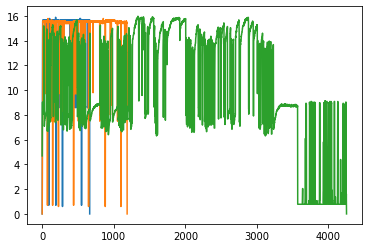

In [165]:
import matplotlib.pyplot as plt

plt.plot(X[300])
plt.plot(X[209])
plt.plot(X[200])

In [133]:
import numpy as np
import pickle

In [134]:
charging_data = {}
charging_data['X'] = X
charging_data['Y'] = Y

In [135]:
# write python dict to a file
output = open('charging_data.pkl', 'wb')
pickle.dump(charging_data, output)
output.close()

In [136]:
# read python dict back from the file
pkl_file = open('charging_data.pkl', 'rb')
output = pickle.load(pkl_file)
pkl_file.close()